In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [30]:
# Set the path to the dataset
base_dir = 'diss_dataset/chest_xray/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


## Visualization

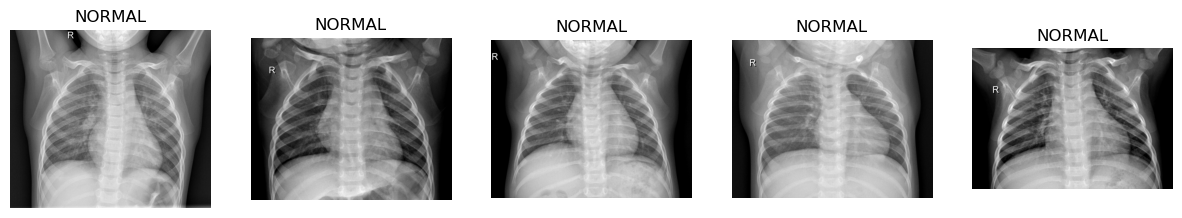

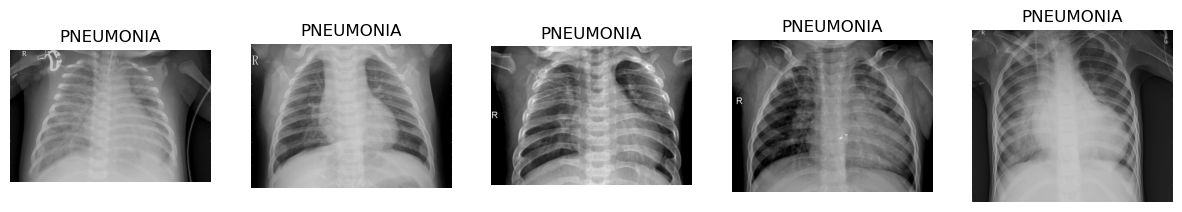

In [31]:
def plot_sample_images(directory, label, num_samples=5):
    folder = os.path.join(directory, label)
    sample_images = os.listdir(folder)[:num_samples]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder, img_name)
        img = plt.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

plot_sample_images(train_dir, 'NORMAL')
plot_sample_images(train_dir, 'PNEUMONIA')


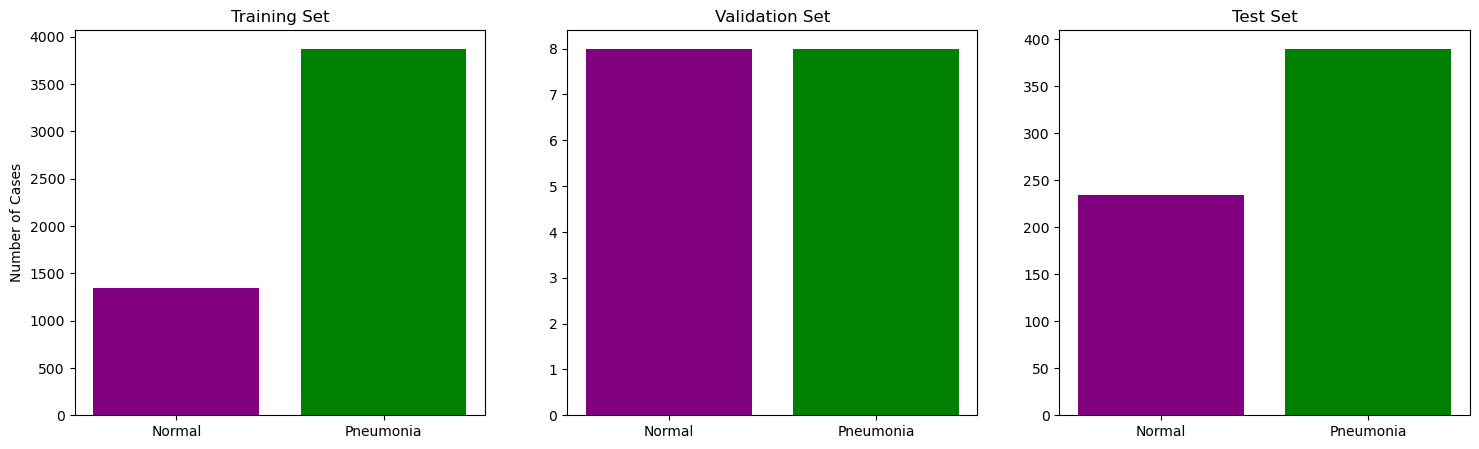

In [32]:
# Define directories for train, validation, and test sets
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(validation_dir, 'NORMAL')
val_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

# Count the number of images in each category
def count_images(directory):
    return len(os.listdir(directory))

train_normal_count = count_images(train_normal_dir)
train_pneumonia_count = count_images(train_pneumonia_dir)

val_normal_count = count_images(val_normal_dir)
val_pneumonia_count = count_images(val_pneumonia_dir)

test_normal_count = count_images(test_normal_dir)
test_pneumonia_count = count_images(test_pneumonia_dir)

# Create bar plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Training set plot
ax[0].bar(['Normal', 'Pneumonia'], [train_normal_count, train_pneumonia_count], color=['purple', 'green'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('Number of Cases')

# Validation set plot
ax[1].bar(['Normal', 'Pneumonia'], [val_normal_count, val_pneumonia_count], color=['purple', 'green'])
ax[1].set_title('Validation Set')

# Test set plot
ax[2].bar(['Normal', 'Pneumonia'], [test_normal_count, test_pneumonia_count], color=['purple', 'green'])
ax[2].set_title('Test Set')

plt.show()


## Data Preprocessing

Preprocessing steps used:
1. Rescaling: Normalizes pixel values to the range [0, 1] for faster convergence and consistent input values.
2. Data Augmentation: Enhances the dataset by applying random transformations (shearing, zooming, flipping) to improve generalization and reduce overfitting.
3. Resizing: Standardizes image dimensions to a fixed size (150x150 pixels) for compatibility with the neural network.
4. Batching: Loads images in small groups (batches) to optimize memory usage and training efficiency.
5. Binary Labels: Ensures labels are in a binary format for binary classification.

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Implementation

In [34]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# Hyperparameter Tuning

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 397ms/step - accuracy: 0.7529 - loss: 0.5303 - val_accuracy: 0.8750 - val_loss: 0.4041
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 348ms/step - accuracy: 0.9082 - loss: 0.2334 - val_accuracy: 0.6250 - val_loss: 0.9149
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 347ms/step - accuracy: 0.9256 - loss: 0.1944 - val_accuracy: 0.6875 - val_loss: 1.0020
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 352ms/step - accuracy: 0.9344 - loss: 0.1744 - val_accuracy: 0.8125 - val_loss: 0.3174
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 348ms/step - accuracy: 0.9351 - loss: 0.1710 - val_accuracy: 0.6875 - val_loss: 0.6282



# Model Evaluation

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.8529 - loss: 0.3261
Test accuracy: 85.90%


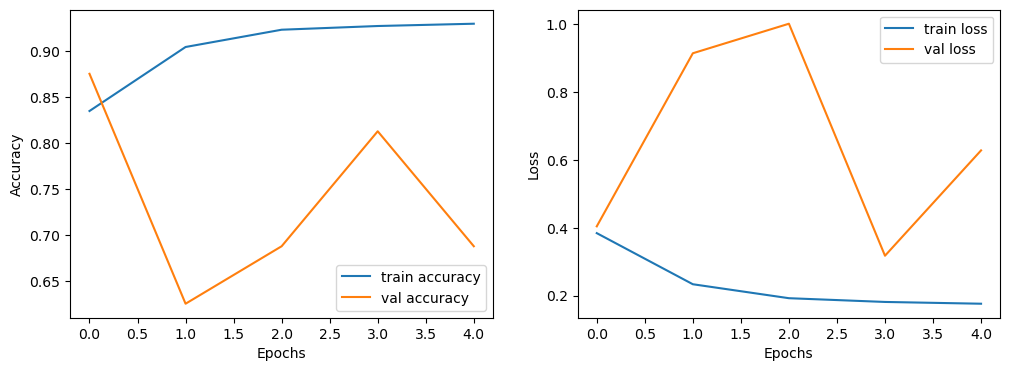

In [36]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Prediction

In [37]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    return 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'

# Predicting a sample image
sample_img_path = os.path.join(test_dir, 'PNEUMONIA', 'person1_virus_6.jpeg')
result = predict_image(sample_img_path)
print(f'The prediction for the sample image is: {result}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The prediction for the sample image is: PNEUMONIA


In [38]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')


163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 282ms/step - accuracy: 0.9384 - loss: 0.1551
Training Accuracy: 0.9404
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.8665 - loss: 0.3025
Test Accuracy: 0.8590


# Different Deep Learning models

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model_vgg16 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8643 - loss: 0.3173 - val_accuracy: 0.8750 - val_loss: 0.3312
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9376 - loss: 0.1617 - val_accuracy: 0.8125 - val_loss: 0.3008
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9448 - loss: 0.1536 - val_accuracy: 0.8125 - val_loss: 0.4135
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9470 - loss: 0.1441 - val_accuracy: 0.7500 - val_loss: 0.5280
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9432 - loss: 0.1533 - val_accuracy: 0.8750 - val_loss: 0.3469
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9450 - loss: 0.1290 - val_accuracy: 0.7500 - val_loss: 0.4701
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9466 - loss: 0.1489 - val_accuracy: 0.7500 - val_loss: 0.3947
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9535 - loss: 0.1290 - val_accu

In [14]:
# Evaluate VGG16 model
train_loss_vgg16, train_accuracy_vgg16 = model_vgg16.evaluate(train_generator, verbose=1)
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_generator, verbose=1)
print(f'VGG16 - Training Accuracy: {train_accuracy_vgg16:.4f}, Test Accuracy: {test_accuracy_vgg16:.4f}')


163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 857ms/step - accuracy: 0.9567 - loss: 0.1168
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 818ms/step - accuracy: 0.9109 - loss: 0.2505
VGG16 - Training Accuracy: 0.9548, Test Accuracy: 0.9167


In [15]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model_resnet50 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 506ms/step - accuracy: 0.6769 - loss: 0.8622 - val_accuracy: 0.5000 - val_loss: 0.7415
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 500ms/step - accuracy: 0.7278 - loss: 0.5763 - val_accuracy: 0.5000 - val_loss: 0.7006
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 497ms/step - accuracy: 0.7372 - loss: 0.5305 - val_accuracy: 0.5000 - val_loss: 0.7133
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 514ms/step - accuracy: 0.7469 - loss: 0.5216 - val_accuracy: 0.5000 - val_loss: 0.7408
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 496ms/step - accuracy: 0.7387 - loss: 0.5128 - val_accuracy: 0.5000 - val_loss: 0.7350
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 493ms/step - accuracy: 0.7456 - loss: 0.5012 - val_accuracy: 0.5000 - val_loss: 0.7032
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - accuracy: 0.7568 - loss: 0.4928 - val_accuracy: 0.5000 - val_loss: 0.6972
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - accuracy: 0.7326 - loss: 0

In [16]:
# Evaluate ResNet50 model
train_loss_resnet50, train_accuracy_resnet50 = model_resnet50.evaluate(train_generator, verbose=1)
test_loss_resnet50, test_accuracy_resnet50 = model_resnet50.evaluate(test_generator, verbose=1)
print(f'ResNet50 - Training Accuracy: {train_accuracy_resnet50:.4f}, Test Accuracy: {test_accuracy_resnet50:.4f}')


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - accuracy: 0.7447 - loss: 0.5135
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.6181 - loss: 0.6174
ResNet50 - Training Accuracy: 0.7429, Test Accuracy: 0.6250


In [17]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model_inceptionv3 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_inceptionv3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - accuracy: 0.8307 - loss: 1.2025 - val_accuracy: 0.7500 - val_loss: 0.9568
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - accuracy: 0.8995 - loss: 0.2291 - val_accuracy: 0.8750 - val_loss: 0.5905
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 371ms/step - accuracy: 0.9137 - loss: 0.2084 - val_accuracy: 0.6875 - val_loss: 1.0613
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 372ms/step - accuracy: 0.9124 - loss: 0.2049 - val_accuracy: 0.7500 - val_loss: 0.5715
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 371ms/step - accuracy: 0.9281 - loss: 0.2112 - val_accuracy: 0.8750 - val_loss: 0.5557
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - accuracy: 0.9243 - loss: 0.1916 - val_accuracy: 0.7500 - val_loss: 0.9997
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 371ms/step - accuracy: 0.9277 - loss: 0.1900 - val_accuracy: 0.7500 - val_loss: 0.8012
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.9348 - loss: 0

In [18]:
# Evaluate InceptionV3 model
train_loss_inceptionv3, train_accuracy_inceptionv3 = model_inceptionv3.evaluate(train_generator, verbose=1)
test_loss_inceptionv3, test_accuracy_inceptionv3 = model_inceptionv3.evaluate(test_generator, verbose=1)
print(f'InceptionV3 - Training Accuracy: {train_accuracy_inceptionv3:.4f}, Test Accuracy: {test_accuracy_inceptionv3:.4f}')

163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.9346 - loss: 0.1717
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.7562 - loss: 0.7527
InceptionV3 - Training Accuracy: 0.9314, Test Accuracy: 0.7901
